<a href="https://colab.research.google.com/github/langfordzd/burst_regimes/blob/main/walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neurodsp
!pip install bycycle
!pip install mne

In [2]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

In [ ]:
#import shutil
#shutil.rmtree('/content/burst_regimes')
!git clone https://github.com/langfordzd/burst_regimes.git

In [4]:
import sys
sys.path.insert(0,'/content/bursts_regimes')
sys.path.append('/content/burst_regimes')


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config, sim, detectors
import itertools
from multiprocessing import Pool, cpu_count
import time
import pickle
from scipy.stats import lognorm
from scipy import ndimage
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12

In [6]:
r_seed = 0
t_num = 500
config.t_num = t_num
depth_point = (1, 50)
cycles = [3, 9]
shape = 0.4
loc = .03
scale = 0.001
distribution = ('lognorm', shape, loc, scale)
probs = [0.3, 0.7]
trials, chars = sim.simmer(r_seed,t_num,depth_point,cycles,distribution,probs)
config.trials = trials

# How did we pick the parameters for each method?

We tried to chose sets of parameters for the CC method that didn't give us false-bursts in 1/f noise as shown [here](https://github.com/langfordzd/burst_regimes/blob/main/parameter_picks.ipynb).

The PT method is roughly based off of previous [research](https://elifesciences.org/articles/29086) in which the mouse data is taken. We simply used the same 6-median cutoff as they did in the paper, because it seemed to perform well there, and fairly well in the simulation - though we did put a 2-cycle cutoff on the method we are carrying forward.



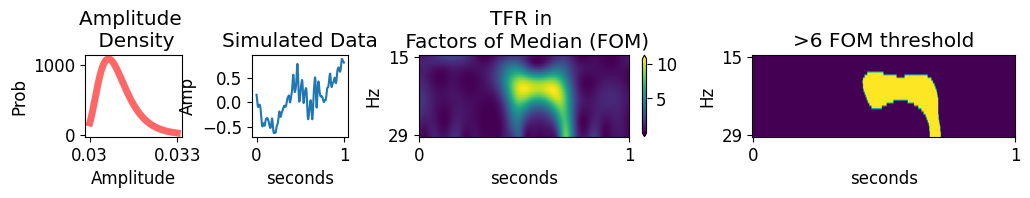

In [21]:
fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(12, 12)
gs.update(wspace=5.5, hspace=0.9)
t = 3
xtr = fig.add_subplot(gs[0:2, 0:2])
dens = np.linspace(lognorm.ppf(0.01, shape,loc=loc,scale=scale),lognorm.ppf(0.99, shape,loc=loc,scale=scale), 1000)
xtr.plot(dens, lognorm.pdf(dens, shape,loc=loc,scale=scale),'r-', lw=5, alpha=0.6, label='amplitude density')
xtr.title.set_text('Amplitude \n Density')
xtr.set_xlabel('Amplitude')
xtr.set_ylabel('Prob')
xtr.set_xticks([np.min(dens), np.max(dens)])
xtr.set_xticklabels([np.around(np.min(dens),3), np.around(np.max(dens),3)])
xtr = fig.add_subplot(gs[0:2, 2:4])
xtr.plot(trials[t][3][250:750])
xtr.title.set_text('Simulated Data')
#xtr.set_yticks([-1, 1])
#xtr.set_yticklabels(['-1', '1'])
xtr.set_xticks([0, 500])
xtr.set_xticklabels(['0', '1'])
xtr.set_xlabel('seconds')
xtr.set_ylabel('Amp')
xtr = fig.add_subplot(gs[0:2, 4:8])
tfr = trials[t][7][:,250:750]
tfr_o = xtr.imshow(tfr,aspect='auto')
cbar = fig.colorbar(tfr_o,ax=xtr, extend='both')
xtr.title.set_text('TFR in \n Factors of Median (FOM)')
xtr.set_yticks([0, 28])
xtr.set_yticklabels(['15', '29'])
xtr.set_xticks([0, 500])
xtr.set_xticklabels(['0', '1'])
xtr.set_xlabel('seconds')
xtr.set_ylabel('Hz')
xtr = fig.add_subplot(gs[0:2, 8:12])
labeled_image, num_features = ndimage.label(tfr>6)
tfr_m = xtr.imshow(labeled_image,aspect='auto')
#cbar = fig.colorbar(tfr_m,ax=xtr, extend='both')
xtr.title.set_text('>6 FOM threshold')
xtr.set_yticks([0, 28])
xtr.set_yticklabels(['15', '29'])
xtr.set_xticks([0, 500])
xtr.set_xticklabels(['0', '1'])
xtr.set_xlabel('seconds')
xtr.set_ylabel('Hz')
plt.show()

In [8]:
pt_recov = [detectors.pow_chars(s) for s in [trials]]
config.pt_recov = pd.DataFrame(list(itertools.chain.from_iterable(pt_recov)),
                        columns=['loc','chan','ep','ids','start','end','duration'])

In [9]:
with open("/content/burst_regimes/wte", "rb") as fp:
   whichToEval = pickle.load(fp)
twos = [4,8,12,13,14,15,16]
threes = [0,1,2,3,5,6,7,9,10,11]
config.whichToEval = whichToEval
trial_index = np.arange(len(trials))
which_index = np.arange(len(whichToEval))
trial_eval_product = list(itertools.product(trial_index, which_index))

In [10]:
start_time = time.time()
num_cores = cpu_count()
pool = Pool(processes=num_cores)
cycler =  pool.starmap(detectors.cycler_worker, trial_eval_product)
pool.close()
pool.join()
print("--- %s minutes ---" % ((time.time() - start_time) / 60))

--- 5.210034382343292 minutes ---


In [11]:
lis = list()
for c in cycler:
    lis.append([c[0],c[1],c[2],c[3],c[4],c[5],c[6],c[7],len(c[8]),len(c[9]),len(c[10]),len(c[11])])
df = pd.DataFrame(lis,columns=['loc', 'chan', 'ep', 'ids', 't', 'toE',
                               'stat', 'count',
                               'ccu','ccc','ptu','ptc'])
evals = []
temp = df
df['has_b'] = df['count']>0
mean = df.groupby('toE').mean()
unis  = df.groupby('toE').sum()
cr = mean[['stat']]
unis  = unis[['ccu','ccc','ptu','ptc','count','has_b']]
unis['stat'] = cr['stat']
unis_twos = unis.iloc[twos]
unis_threes = unis.iloc[threes]
max2 = unis_twos['stat'].argmax()
max3 = unis_threes['stat'].argmax()
idx2 = unis_twos.index[max2]
idx3 = unis_threes.index[max3]
evals = [idx2,idx3]#.append([idx2,idx3])

<ipython-input-11-7f11fb801c04>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean = df.groupby('toE').mean()
<ipython-input-11-7f11fb801c04>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unis  = df.groupby('toE').sum()


In [12]:
indices2 = [i for i, x in enumerate(cycler) if x[5] == evals[0]]
indices3 = [i for i, x in enumerate(cycler) if x[5] == evals[1]]
temp2 = [cycler[index] for index in indices2]
temp3 = [cycler[index] for index in indices3]

cc_uniq = pd.concat([i[8] for i in temp2])
cc_comm = pd.concat([i[9] for i in temp2])
cc_uniq3 = pd.concat([i[8] for i in temp3])
cc_comm3 = pd.concat([i[9] for i in temp3])
cc_uniq['which'] = 'cc2'
cc_comm['which'] = 'co2'
cc_uniq3['which'] = 'cc3'
cc_comm3['which'] = 'co3'
ccs = pd.concat([cc_uniq,cc_comm,cc_uniq3,cc_comm3])
gb = ccs.groupby(['ids'])

cc_drop_overlaps = []
for name, g in gb:
    g = g.sort_values(by='end', ascending=False)
    g['overlap'] = g['end'].gt(g['start'].shift(fill_value=0))
    g['group'] = g['overlap'].eq(False).cumsum()
    g = g.drop_duplicates(subset='group').drop(columns=['overlap','group'])
    cc_drop_overlaps.append(g)

cc = pd.concat(cc_drop_overlaps)
##%% this is confusing because some are the same, some overlap becuase of imregionalmax
pt_uniq2 = pd.concat([i[10] for i in temp2])
pt_uniq3 = pd.concat([i[10] for i in temp3])
pt_uniq = pd.concat([pt_uniq2,pt_uniq3]).drop_duplicates().reset_index(drop=True)
pt_comm2 = pd.concat([i[11] for i in temp2])
pt_comm3 = pd.concat([i[11] for i in temp3])
pt_comm = pd.concat([pt_comm2,pt_comm3]).drop_duplicates().reset_index(drop=True)
pt_uniq['which'] = 'pt'
pt_comm['which'] = 'pt_com'
pt = pd.concat([pt_uniq, pt_comm])
#you can have a common in pt with cc2 or cc3, so you have to drop all commons, based on cc2 or 3, not just one
pt.drop_duplicates(subset=['ids', 'start','end'], keep=False,inplace=True,ignore_index=True)
pt = pt[pt['which']=='pt']
com1 = pd.concat([cc, pt])#, cc_comm, pt_comm])
com1['which'] = com1['which'].replace(['cc2','cc3','pt','co2','co3','pt_com'],['cc','cc','pt','co','co','co'])

<ipython-input-12-fa8ae4ae9649>:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, g in gb:


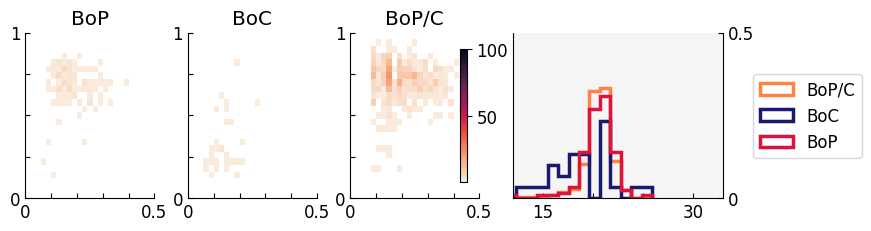

In [15]:
fig = plt.figure(1, figsize=(9, 12))
gs = gridspec.GridSpec(9, 9)
gs.update(wspace=0.7, hspace=0.9)
v_val = 100

xtr = fig.add_subplot(gs[0:2, 0:2])
sub = com1[com1['which']=='pt']
c = sns.color_palette("rocket_r", as_cmap=True)
xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1,vmin=1, vmax=v_val,
             range=[[0, 0.5], [0, 1]])
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(ylabel='',xlabel='')
xtr.set_title('BoP')
xtr.yaxis.set_label_coords(-0.05, 0.5)
xtr.xaxis.set_label_coords(0.5, -0.05)
###############################################################################
xtr = fig.add_subplot(gs[0:2, 2:4])
sub = com1[com1['which']=='cc']
p = xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1, vmin=1, vmax=v_val,
              range=[[0, 0.5], [0, 1]])
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(xlabel=None,ylabel=None)
xtr.set_title('BoC')
###############################################################################
xtr = fig.add_subplot(gs[0:2, 4:6])
sub = com1[com1['which']=='co']
p = xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1,vmin=1, vmax=v_val,
              range=[[0, 0.5], [0, 1]])
plt.colorbar(p[3],ax=xtr, shrink=0.8, pad = -0.15)
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(xlabel=None,ylabel=None)
xtr.set_title('BoP/C')

qs = ['#191970','#DC143C','#FF8247']
xtr = fig.add_subplot(gs[0:2, 6:9])
cc = com1['freq'][com1['which']=='cc']
pt = com1['freq'][com1['which']=='pt']
co = com1['freq'][com1['which']=='co']
xtr.hist([pt,cc,co], 25, histtype='step', stacked=False, fill=False,
            color=[qs[1],qs[0],qs[2]], density=True, label=['BoP','BoC','BoP/C'],
            linewidth=2.5)
xtr.legend(bbox_to_anchor=(1.7, 0.8))
xtr.set_ylim([0, 0.5])
xtr.set_xlim([12, 33])
xtr.spines['left'].set_visible(True)
xtr.spines['top'].set_visible(False)
xtr.yaxis.tick_right()
xtr.yaxis.set_label_position("right")
xtr.set_yticks([0, 0.5])
xtr.set_yticklabels(['0', '0.5'])
xtr.set_xticks([15, 20, 25, 30])
xtr.set_xticklabels(['15', '', '', '30'])
xtr.tick_params(axis="both",direction="in")
xtr.set(ylabel='',xlabel='')
xtr.yaxis.set_label_coords(-0.05, 0.5)
xtr.set_facecolor('whitesmoke')
plt.show()